In [90]:
import pandas as pd

In [91]:
df = pd.read_csv('/Users/ASUS/DSC-PLAT-CHALLENGE/data/train_preprocess.tsv.txt', sep='\t', names=['text', 'label'])

In [92]:
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [93]:
df.shape

(11000, 2)

In [94]:
df.label.value_counts()

label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

In [95]:
import re

def cleansing (text):
    string = text.lower()
    string = re.sub(r'[^a-zAZ0-9]', ' ', string)
    string = re.sub(r'@\w+', '', string)  # Menghilangkan username twitter
    string = re.sub(r'\b(rt|RT)\b', '', string)  # Menghilangkan tulisan RT (Retweet)
    string = re.sub(r'\W+', ' ', string)  # Menghilangkan tanda baca
    string = re.sub(r'\s+', ' ', string).strip()  # Menghilangkan whitespace yang tidak diperlukan
    string = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(https?://[^\s]+))', ' ', string)  # Menghilangkan semua URL yang ada
    string = re.sub(' +', ' ', string) # Menghilangkan spasi yang berlebihan
    return string

In [96]:
df['text_clean'] = df.text.apply(cleansing)

In [97]:
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung tem...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...


In [98]:
# Klasifikasi data 3 sentimen
neg = df.loc[df['label'] == 'negative'].text_clean.to_list()
neu = df.loc[df['label'] == 'neutral'].text_clean.to_list()
pos = df.loc[df['label'] == 'positive'].text_clean.to_list()

neg_label = df.loc[df['label'] == 'negative'].label.to_list()
neu_label = df.loc[df['label'] == 'neutral'].label.to_list()
pos_label = df.loc[df['label'] == 'positive'].label.to_list()

In [99]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


In [106]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 10000
tokenizer = Tokenizer(num_words = max_features, split = ' ', lower = True)
tokenizer.fit_on_texts(total_data)
with open('resources_of_lstm/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('resources_of_lstm/x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol= pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [101]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('resources_of_lstm/y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol = pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [102]:
from sklearn.model_selection import train_test_split

file = open("resources_of_lstm/x_pad_sequences.pickle", 'rb')
X = pickle.load(file)
file.close()

file = open("resources_of_lstm/y_labels.pickle", 'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [35]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.7419 - loss: 0.6184 - val_accuracy: 0.8736 - val_loss: 0.3295
Epoch 2/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.9263 - loss: 0.2029 - val_accuracy: 0.8818 - val_loss: 0.3312
Epoch 2: early stopping


In [36]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       685
           1       0.88      0.73      0.80       233
           2       0.91      0.93      0.92      1282

    accuracy                           0.88      2200
   macro avg       0.87      0.84      0.85      2200
weighted avg       0.88      0.88      0.88      2200



In [37]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train = X[data[0]]
    target_train = y[data[0]]

    data_test = X[data[1]]
    target_test = y[data[1]]
    
    model = Sequential()
    model.add(Embedding(max_features, embed_dim))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print("Rata-rata Accuracy:", average_accuracy)

Epoch 1/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.7541 - loss: 0.5860 - val_accuracy: 0.8727 - val_loss: 0.3362
Epoch 2/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.9216 - loss: 0.2184 - val_accuracy: 0.8741 - val_loss: 0.3591
Epoch 2: early stopping
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.81      0.87      0.83       685
           1       0.86      0.72      0.79       233
           2       0.92      0.91      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.86      0.83      0.84      2200
weighted avg       0.88      0.87      0.87      2200

Epoch 1/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.7588 - loss: 0.6003 - val_accuracy: 0.8755 - val_loss: 0.3390
Epoch 2/10
880/880 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - accuracy: 0.9224 - loss: 0.2150 - val_accuracy: 0.8805 - val_loss: 0.3301
Epoch 3/10
880/880 ━

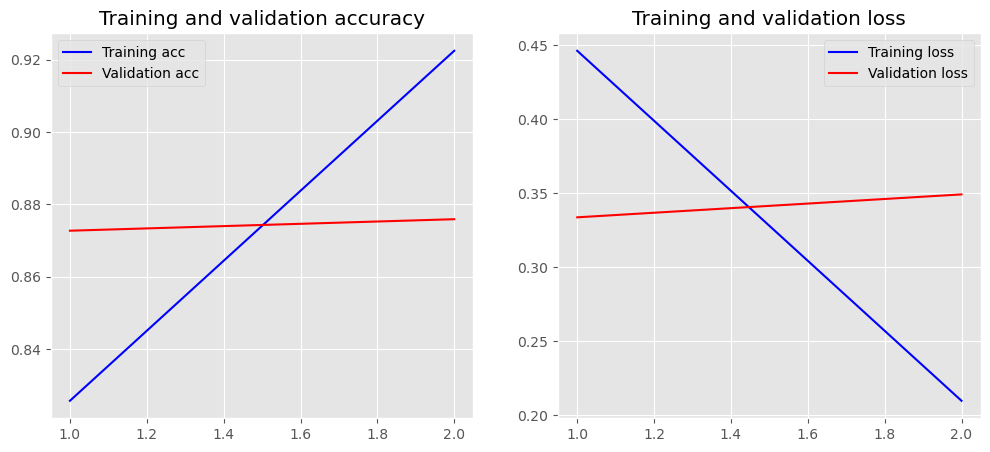

In [41]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [103]:
model.save('model/model_of_lstm/model_lstm.h5')
print("Model has created")

Model has created


In [104]:
import re
from keras.models import load_model

input_text = """
KAmu itu sudah terlampau Bodoh!!@
"""

def cleansing(text):

    string = text.lower()

    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [105]:
sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model/model_of_lstm/model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ", text[0])
print("Sentiment: ", sentiment[polarity])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Text:   kamu itu sudah terlampau bodoh    
Sentiment:  negative


In [58]:
import pandas as pd

file_path = '/Users/ASUS/DSC-PLAT-CHALLENGE/data/data.csv'  
data = pd.read_csv(file_path, encoding='latin-1')

texts = data['Tweet'].tolist()

def cleansing(text):

    string = text.lower()

    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    string = re.sub(r'@\w+', '', string)
    string = re.sub(r'\b(rt|RT)\b', '', string) 
    string = re.sub(r'\W+', ' ', string) 
    string = re.sub(r'\s+', ' ', string).strip()  
    string = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(https?://[^\s]+))', ' ', string)
    string = re.sub(' +', ' ', string)
    return string

In [62]:
sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ", text[0])
print("Sentiment: ", sentiment[polarity])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
Text:  disaat semua cowok berusaha melacak perhatian gue loe lantas remehkan perhatian yg gue kasih khusus ke elo basic elo cowok bego
Sentiment:  negative
